Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import nnls
from collections import defaultdict
from sklearn.metrics import mean_squared_error

Preparing Data

In [2]:
prices_df = pd.read_csv('data\Russell3000_prices_clean.csv')
prices_df['Date'] = pd.to_datetime(prices_df['Date'], dayfirst=True)
prices_df.sort_values(by='Date', inplace=True)  # prices_df is modified in place, and there's no new DataFrame returned

returns_df = pd.DataFrame(index=prices_df.index)
returns_df['Date'] = prices_df['Date']

selected_stocks = prices_df.columns[1:]

Returns of Selected Stocks

In [3]:
# Create a list to store DataFrames for each stock's returns
stock_returns_df = []

# Iterate over selected stocks
for stock in selected_stocks:
    # Calculate returns for the stock
    stock_returns = prices_df[stock].pct_change()

    # Append the stock's returns DataFrame to the list
    stock_returns_df.append(pd.DataFrame({stock: stock_returns}))

# Concatenate all the stock's returns DataFrames into a single DataFrame
returns_df = pd.concat([returns_df] + stock_returns_df, axis=1).dropna().reset_index(drop=True)

# Delete unnecessary variables
del stock_returns_df

In [4]:
'''x = 0
y = 0
for stock in selected_stocks:
    x += returns_df[stock].std()*252**0.5
    y += 1
print(x/y)'''

'x = 0\ny = 0\nfor stock in selected_stocks:\n    x += returns_df[stock].std()*252**0.5\n    y += 1\nprint(x/y)'

Volatility Estimators' Correlation Table

In [5]:
# Create an empty DataFrame with the desired columns
correlations_df = [["Estimators", "T=12m", "T=6m", "T=3m", "T=1m"]]

SAMPLE

In [6]:
def calculate_rolling_std(data, window):
    n = len(data)
    std_values = [data[i-window:i].std() if i >= window else None for i in range(n)]
    return pd.Series(std_values, index=data.index)

'''def sample_corr(returns=returns_df, stocks=selected_stocks,  windows = [21*12, 21*6, 21*3, 21*1]):
    volatility_in_sample = pd.DataFrame(index=returns.index)
    volatility_in_sample['Date'] = returns['Date']
    volatility_out_of_sample = pd.DataFrame(index=returns.index)
    volatility_out_of_sample['Date'] = returns['Date']
    # Define the window size for monthly calculations
    window_out_of_sample = 21  # 21 trading days in a month

    correlations = ['SAMPLE']

    for window in windows:
        # Calculate volatility rolling window
        for stock in stocks:
            volatility_in_sample[stock] = returns[stock].rolling(window=window).std()
            volatility_out_of_sample[stock] = returns[stock].rolling(window=window_out_of_sample).std()

        # Trim the DataFrames to match the length of the smaller rolling window
        volatility_in_sample = volatility_in_sample.iloc[window:]
        volatility_in_sample = volatility_in_sample.iloc[:-window_out_of_sample].dropna().reset_index(drop=True)
        volatility_out_of_sample = volatility_out_of_sample.iloc[window_out_of_sample + window:].reset_index(drop=True)

    
        correlation = {}
        for stock in selected_stocks:
            in_sample_volatility = volatility_in_sample[stock]
            out_of_sample_volatility = volatility_out_of_sample[stock]
            correlation[stock] = in_sample_volatility.corr(out_of_sample_volatility)

        correlations.append(sum(correlation.values()) / len(correlation))
    return correlations


correlations_df.append(sample_corr())'''

"def sample_corr(returns=returns_df, stocks=selected_stocks,  windows = [21*12, 21*6, 21*3, 21*1]):\n    volatility_in_sample = pd.DataFrame(index=returns.index)\n    volatility_in_sample['Date'] = returns['Date']\n    volatility_out_of_sample = pd.DataFrame(index=returns.index)\n    volatility_out_of_sample['Date'] = returns['Date']\n    # Define the window size for monthly calculations\n    window_out_of_sample = 21  # 21 trading days in a month\n\n    correlations = ['SAMPLE']\n\n    for window in windows:\n        # Calculate volatility rolling window\n        for stock in stocks:\n            volatility_in_sample[stock] = returns[stock].rolling(window=window).std()\n            volatility_out_of_sample[stock] = returns[stock].rolling(window=window_out_of_sample).std()\n\n        # Trim the DataFrames to match the length of the smaller rolling window\n        volatility_in_sample = volatility_in_sample.iloc[window:]\n        volatility_in_sample = volatility_in_sample.iloc[:-window

In [7]:
'''def sample_corrs(returns=returns_df, stocks=selected_stocks,  windows = [21*12, 21*6, 21*3, 21*1]):
    volatility_in_sample = pd.DataFrame(index=returns.index)
    volatility_in_sample['Date'] = returns['Date']
    volatility_out_of_sample = pd.DataFrame(index=returns.index)
    volatility_out_of_sample['Date'] = returns['Date']
    # Define the window size for monthly calculations
    window_out_of_sample = 21  # 21 trading days in a month

    correlations = []

    for window in windows:
        # Calculate annual volatility using a 252-day rolling window
        for stock_symbol in stocks:
            volatility_in_sample[stock_symbol] = returns[stock_symbol].rolling(window=window).std()

        # Calculate monthly volatility using a 21-day rolling window
        for stock_symbol in stocks:
            volatility_out_of_sample[stock_symbol] = returns[stock_symbol].rolling(window=window_out_of_sample).std()

        # Trim the DataFrames to match the length of the smaller rolling window
        volatility_in_sample = volatility_in_sample.tail(len(volatility_in_sample) - window)
        volatility_in_sample = volatility_in_sample.head(len(volatility_in_sample) - window_out_of_sample).reset_index(drop=True)
        volatility_out_of_sample = volatility_out_of_sample.tail(len(volatility_out_of_sample) - (window_out_of_sample + window)).reset_index(drop=True)

    
        correlation = {}
        for stock_symbol in selected_stocks:
            in_sample_volatility = volatility_in_sample[stock_symbol]
            out_of_sample_volatility = volatility_out_of_sample[stock_symbol]
            correlation[stock_symbol] = in_sample_volatility.corr(out_of_sample_volatility)

        correlations.append(sum(correlation.values()) / len(correlation))
    return correlations

print(sample_corrs())'''

"def sample_corrs(returns=returns_df, stocks=selected_stocks,  windows = [21*12, 21*6, 21*3, 21*1]):\n    volatility_in_sample = pd.DataFrame(index=returns.index)\n    volatility_in_sample['Date'] = returns['Date']\n    volatility_out_of_sample = pd.DataFrame(index=returns.index)\n    volatility_out_of_sample['Date'] = returns['Date']\n    # Define the window size for monthly calculations\n    window_out_of_sample = 21  # 21 trading days in a month\n\n    correlations = []\n\n    for window in windows:\n        # Calculate annual volatility using a 252-day rolling window\n        for stock_symbol in stocks:\n            volatility_in_sample[stock_symbol] = returns[stock_symbol].rolling(window=window).std()\n\n        # Calculate monthly volatility using a 21-day rolling window\n        for stock_symbol in stocks:\n            volatility_out_of_sample[stock_symbol] = returns[stock_symbol].rolling(window=window_out_of_sample).std()\n\n        # Trim the DataFrames to match the length of 

Exponential Weighted Variance Estimator

In [8]:
# def get_exp_weights(size, const=0.94):

#     weights = [const**i for i in range(1, size + 1)]
#     suma = sum(weights)
#     weights = [weight / suma for weight in weights]

#     return weights


# def ewma (weights, returns):
#     variance = sum(weights * returns**2)
#     return variance**0.5
    
# def EWMA (selected_stocks = selected_stocks, returns = returns_df, windows = [21*12, 21*6, 21*3, 21*1]):
#     volatility_out_of_sample = pd.DataFrame(index=returns.index)
#     volatility_out_of_sample['Date'] = returns['Date']
#     window_out_of_sample = 21  # 21 trading days in a month
  
#     # Define the window size for monthly calculations
#     correlations = ['EWMA']
#     for window in windows:
#         weights = get_exp_weights(window)
#         correlation = {}
#         # Calculate monthly volatility using a 21-day rolling window
#         for stock_symbol in selected_stocks:
#             value = []

#             for i in range(len(returns[stock_symbol]) - window - window_out_of_sample):
                
#                 window_returns = returns[stock_symbol][i:i + len(weights)]
#                 window_returns = window_returns[::-1]
#                 value.append(lstsq(weights, window_returns))
            
#             value = value[0:]
#             print(value)

#             volatility_out_of_sample[stock_symbol] = returns[stock_symbol].rolling(window=window_out_of_sample).std()

#             vola1 = volatility_out_of_sample[stock_symbol].tail(len(volatility_out_of_sample) - (window_out_of_sample + window)).reset_index(drop=True)
#             print(vola1)
#             correlation[stock_symbol] = np.corrcoef(vola1, value)[0, 1]
#         correlations.append(sum(correlation.values()) / len(correlation))
#     return correlations

# correlations_df.append(EWMA())

Portfelj

2.898238906159901


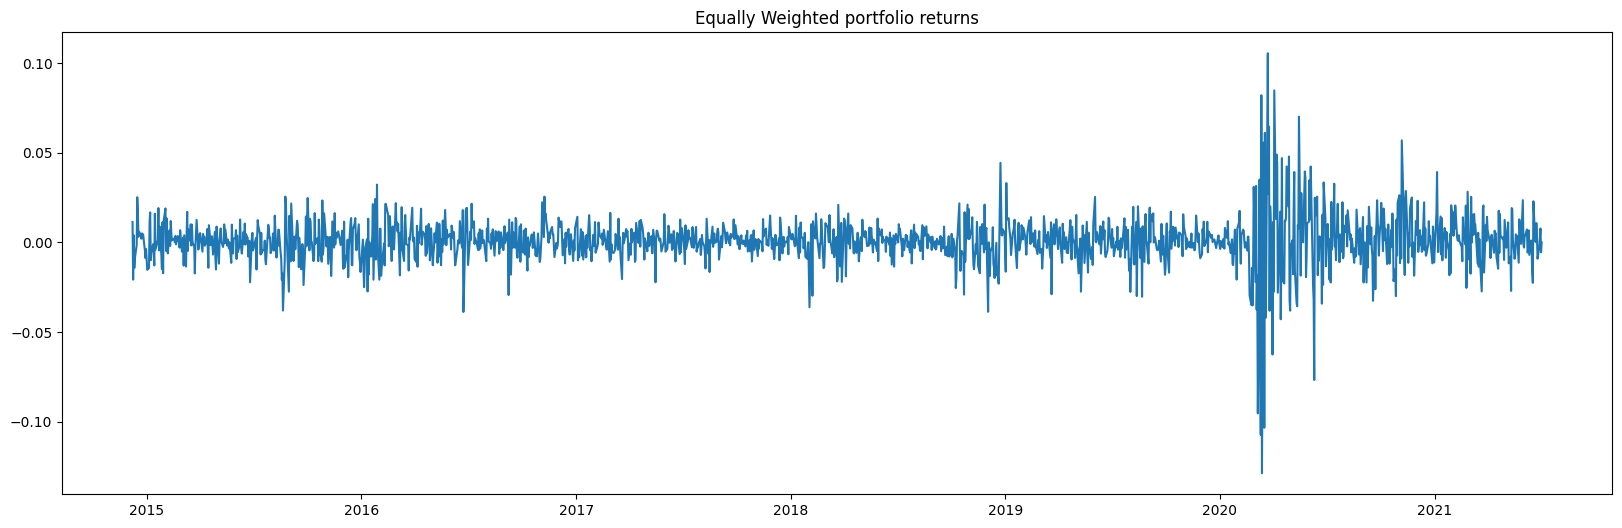

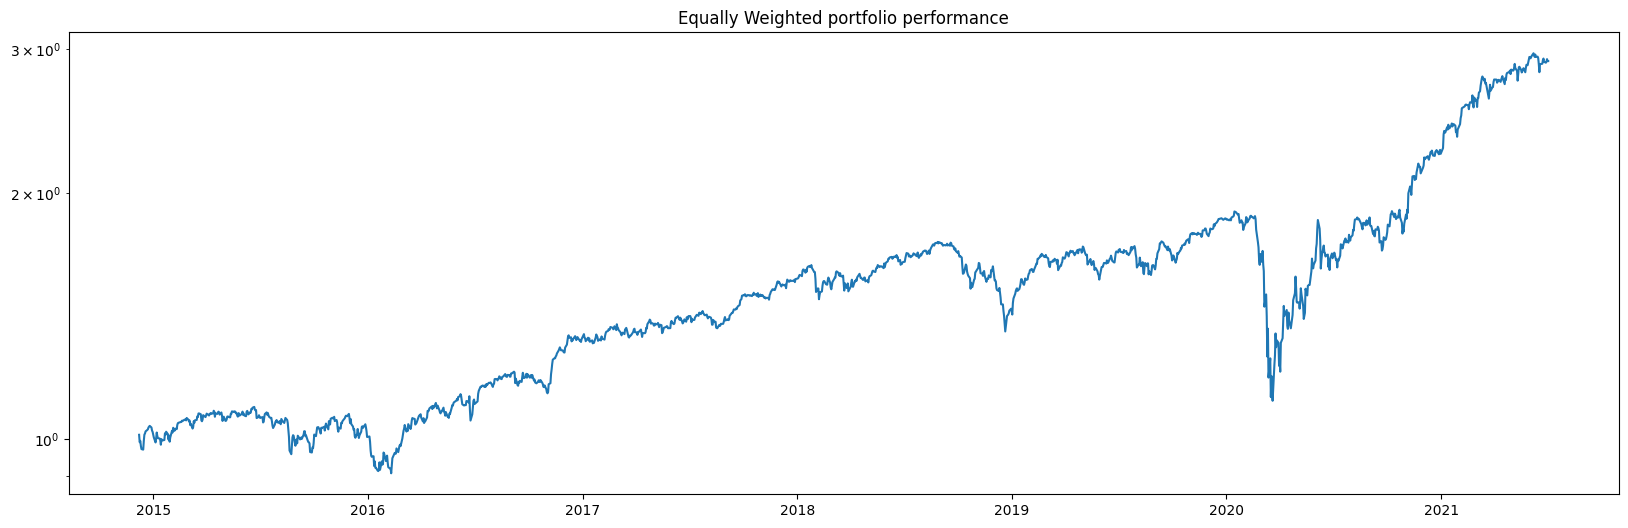

In [9]:
def get_portf_weights(volatilnost):
    zbroj = 0
    weights = {}

    for stock in selected_stocks:
        if volatilnost[stock] != 0:
            zbroj = zbroj + 1 / volatilnost[stock]

    for stock in selected_stocks:   
        if volatilnost[stock] != 0:
            weights[stock] = (1 / volatilnost[stock]) / zbroj
        else:
            weights[stock] = 0

    return weights

matrix = returns_df.iloc[:, 1:].to_numpy()
window = 21*12
start = 0 + 252*15
end = len(prices_df) -21-252*0
ukupno_eq = [1]
povrat_eq = []

for i in range(start, end, 21):
    real_end = i + 20
    volatilnost = {}
    for stock in selected_stocks:
        volatilnost[stock] = 1
    
    #racunamo tezine s obzirom na volatilnost
    weights = get_portf_weights(volatilnost) # 1/len(volatilnost)
    #za svaki dan racunamo promjenu u portfelju

    vector = np.array(list(weights.values()))
    eq_returns = np.dot(matrix[i:i+21], vector)
    for ret in eq_returns:
        povrat_eq.append(ret)
        ukupno_eq.append((ret+1)*ukupno_eq[-1])

print(ukupno_eq[-1])
dates = returns_df.iloc[start-1:real_end, 0]

plt.figure(figsize=(20, 6))
plt.plot(dates, povrat_eq)
plt.title("Equally Weighted portfolio returns")
plt.show()

plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_eq[1:])
plt.title("Equally Weighted portfolio performance")
plt.show()

In [10]:
predicted_lsq_volatility = defaultdict(list)
observed_volatility = defaultdict(list)
predicted_ewma_volatility = defaultdict(list)
predicted_smp_volatility = defaultdict(list)
predicted_lsq_stock_volatility = defaultdict(list)


for i in range(start, end, 21):
    for stock in selected_stocks:
        window_returns = returns_df[stock][i:i + 21]
        observed_volatility[stock].append(window_returns.std())

2.540577582679194


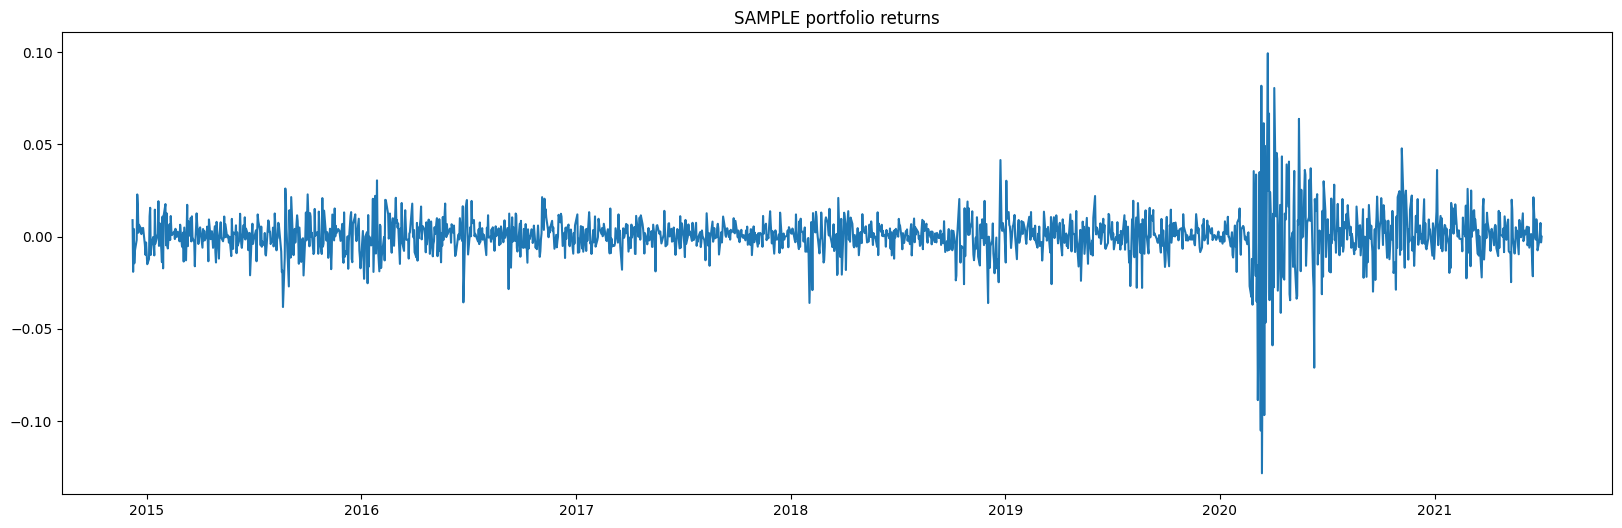

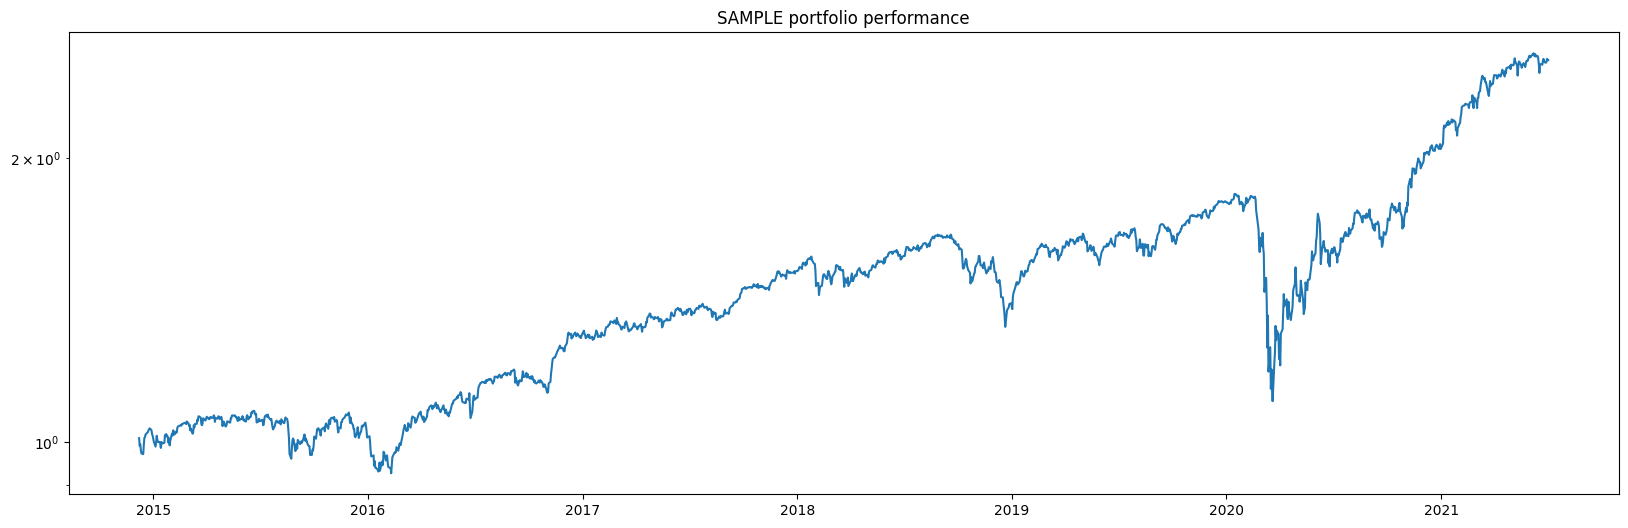

In [11]:
ukupno_sample = [1]
povrat_sample = []

#za svaki mjesec se pomicemo i racunamo volatilnost u intervalu godinu dana
for i in range(start, end, 21):
    volatilnost = {}
    for stock in selected_stocks:
        volatilnost[stock] = returns_df[stock][i - window: i].std()

        predicted_smp_volatility[stock].append(volatilnost[stock])
    
    #racunamo tezine s obzirom na volatilnost
    weights = get_portf_weights(volatilnost) # 1/len(volatilnost)
    #za svaki dan racunamo promjenu u portfelju

    vector = np.array(list(weights.values()))
    sample_returns = np.dot(matrix[i:i+21], vector)
    for ret in sample_returns:
        povrat_sample.append(ret)
        ukupno_sample.append((ret+1)*ukupno_sample[-1])

print(ukupno_sample[-1])

plt.figure(figsize=(20, 6))
plt.plot(dates, povrat_sample)
plt.title("SAMPLE portfolio returns")
plt.show()

plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_sample[1:])
plt.title("SAMPLE portfolio performance")
plt.show()

2.5504081262459493


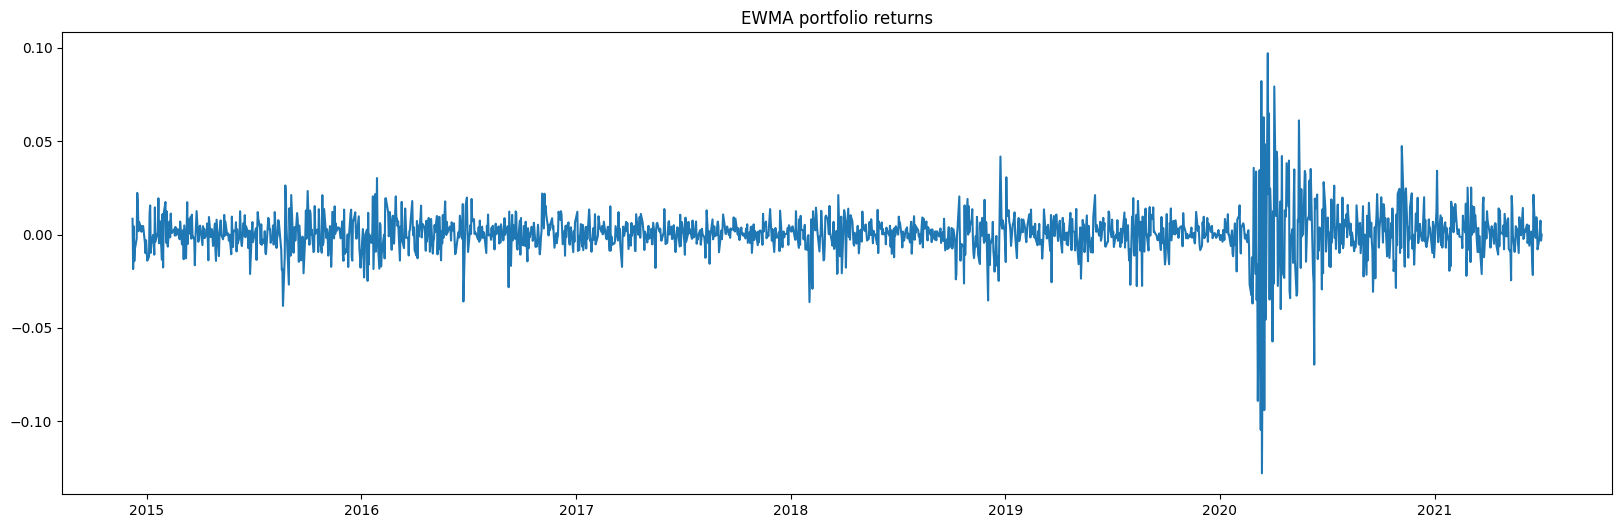

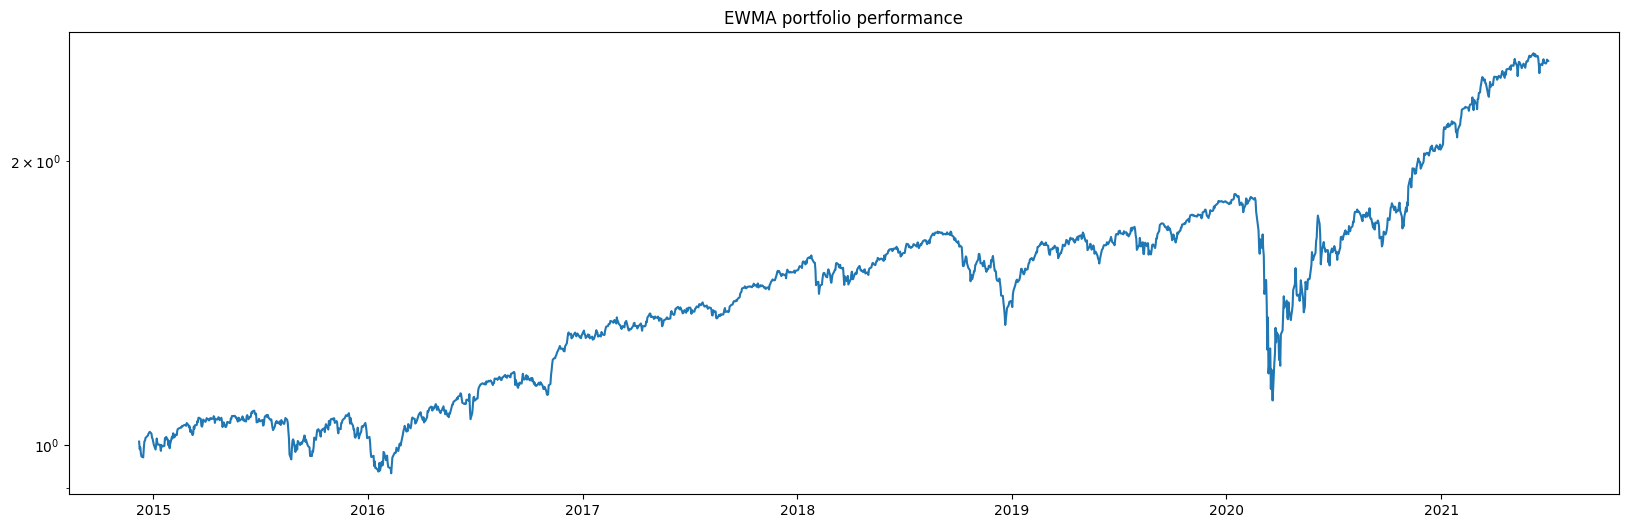

In [12]:
ukupno_ewma = [1]
povrat_ewma = []
def get_exp_weights(size, const=0.94):

    weights = [const**i for i in range(size, 0, -1)]
    suma = sum(weights)
    weights = [weight / suma for weight in weights]

    return weights


def ewma (weights, returns):
    variance = sum(weights * returns**2)
    return variance**0.5

#za svaki mjesec se pomicemo i racunamo volatilnost u intervalu godinu dana
for i in range(start, end, 21):
    weights = get_exp_weights(window)
    volatilnost = {}
    for stock in selected_stocks:
        window_returns = returns_df[stock][i - window: i]
        volatilnost[stock] = ewma(weights, window_returns)

        predicted_ewma_volatility[stock].append(volatilnost[stock])

    
    #racunamo tezine s obzirom na volatilnost
    weights = get_portf_weights(volatilnost) # 1/len(volatilnost)
    #za svaki dan racunamo promjenu u portfelju
    

    vector = np.array(list(weights.values()))
    ewma_returns = np.dot(matrix[i:i+21], vector)
    for ret in ewma_returns:
        povrat_ewma.append(ret)
        ukupno_ewma.append((ret+1)*ukupno_ewma[-1])

print(ukupno_ewma[-1])

plt.figure(figsize=(20, 6))
plt.plot(dates, povrat_ewma)
plt.title("EWMA portfolio returns")
plt.show()

plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_ewma[1:])
plt.title("EWMA portfolio performance")
plt.show()

In [13]:
nnls_window = 21
maxit = 3*100

def get_lstsq_betas(end):
    A = []
    B = []

    for i in range(0, end - nnls_window * 2, 21):
        for stock in selected_stocks:
            A.append(returns_df[stock][i:i + nnls_window] ** 2)
            B.append(returns_df[stock][i + 21:i + 21 * 2].var())

    A = np.array(A)  # Convert list of arrays to a single 2D array
    B = np.array(B)  # Convert list of arrays to a single 2D array
    
    X, residuals = nnls(A, B, maxit*A.shape[1])

    return X

betas = get_lstsq_betas(start)

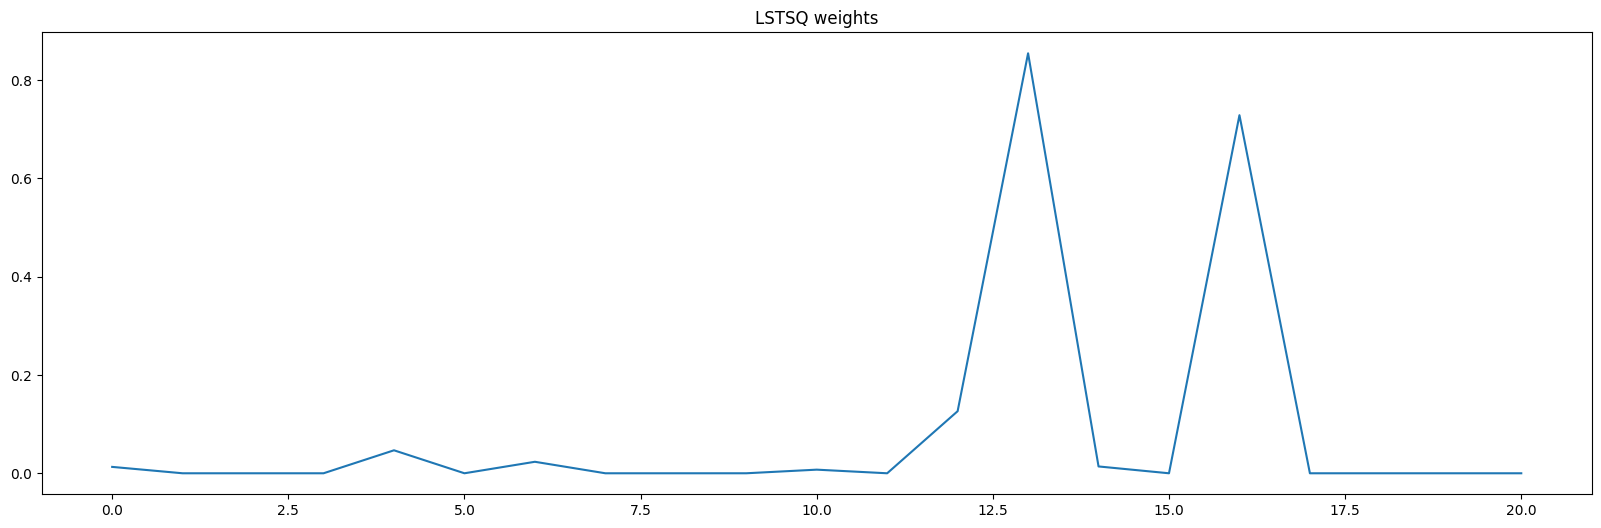

In [14]:
plt.figure(figsize=(20, 6))
plt.plot(betas)
plt.title("LSTSQ weights")
plt.show()

2.6802705164729055


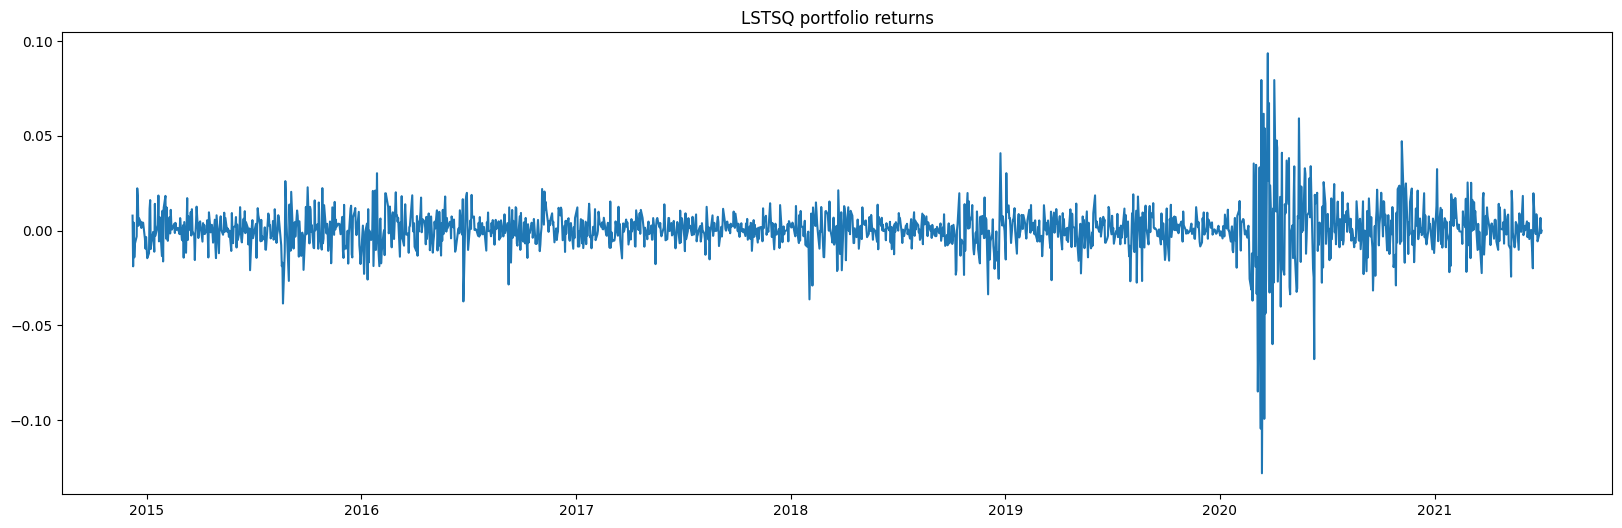

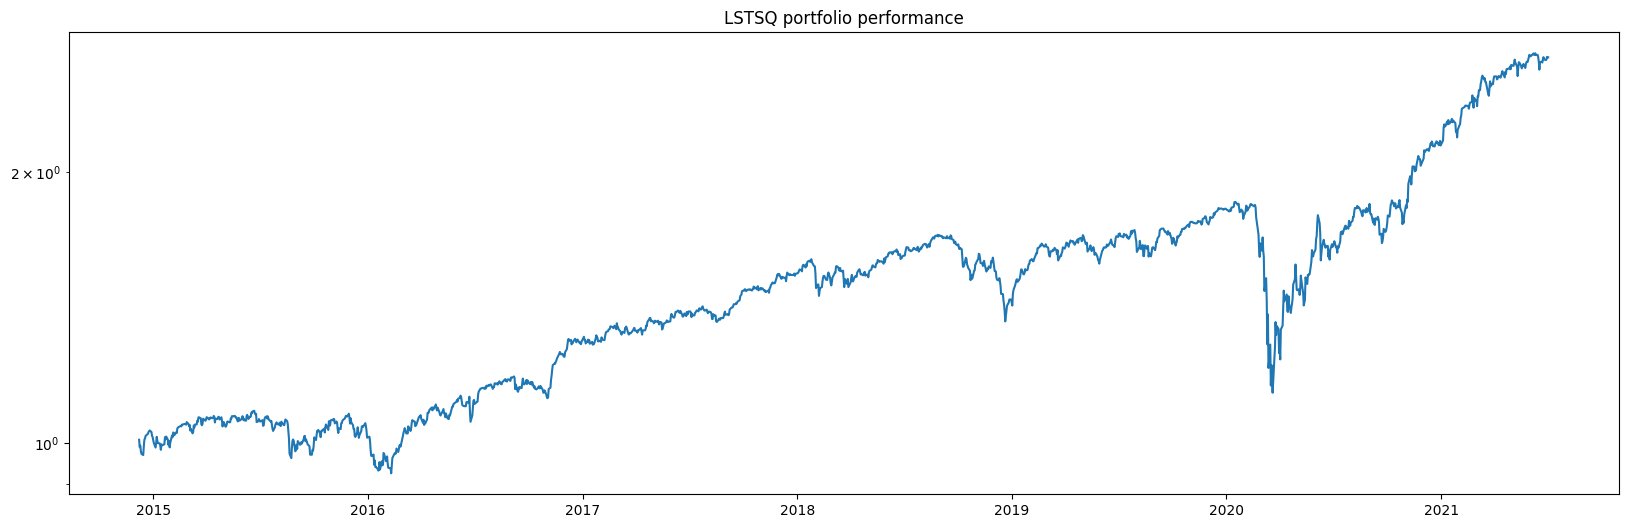

In [15]:
ukupno_lstsq = [1]
povrat_lstsq = []

def lstsq(weights, returns):
    weights_array = np.array(list(weights))  # Convert dictionary keys to an array with appropriate dtype
    returns_array = returns.values
    var = np.sum(weights_array * returns_array ** 2)  # Calculate variance
    return var**0.5

#za svaki mjesec se pomicemo i racunamo volatilnost u intervalu godinu dana
for i in range(start, end, 21):
    volatility = {}
    for stock in selected_stocks:
        window_returns = returns_df[stock][i-len(betas):i]
        volatility[stock] = lstsq(betas, window_returns)
 
        predicted_lsq_volatility[stock].append(volatility[stock])

    
    #racunamo tezine s obzirom na volatilnost
    weights = get_portf_weights(volatility) # 1/len(volatilnost)
    #za svaki dan racunamo promjenu u portfelju
    

    vector = np.array(list(weights.values()))
    lstsq_returns = np.dot(matrix[i:i+21], vector)
    for ret in lstsq_returns:
        povrat_lstsq.append(ret)
        ukupno_lstsq.append((ret+1)*ukupno_lstsq[-1])

print(ukupno_lstsq[-1])

plt.figure(figsize=(20, 6))
plt.plot(dates, povrat_lstsq)
plt.title("LSTSQ portfolio returns")
#plt.xticks(np.arange(0, len(povrat_sample), 252), np.arange(2001, 2022, 1))
plt.show()

plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_lstsq[1:])
plt.title("LSTSQ portfolio performance")
#plt.xticks(np.arange(0, len(ukupno_sample), 252), np.arange(2001, 2022, 1))
plt.show()

In [16]:
def get_lstsq_stock_betas(stock, end):
    A = []  # Initialize empty list for A
    B = []  # Initialize empty list for B

    for i in range(0, end - 21 * 2, 21):
        A.append(returns_df[stock][i:i + nnls_window] ** 2)
        B.append(returns_df[stock][i + nnls_window:i + nnls_window + 21].var())

    A = np.array(A)  # Convert list of arrays to a single 2D array
    B = np.array(B)  # Convert list of arrays to a single 2D array
    
    X, residuals = nnls(A, B)

    return X

betas = {}
for stock in selected_stocks:
    betas[stock] = get_lstsq_stock_betas(stock, start)

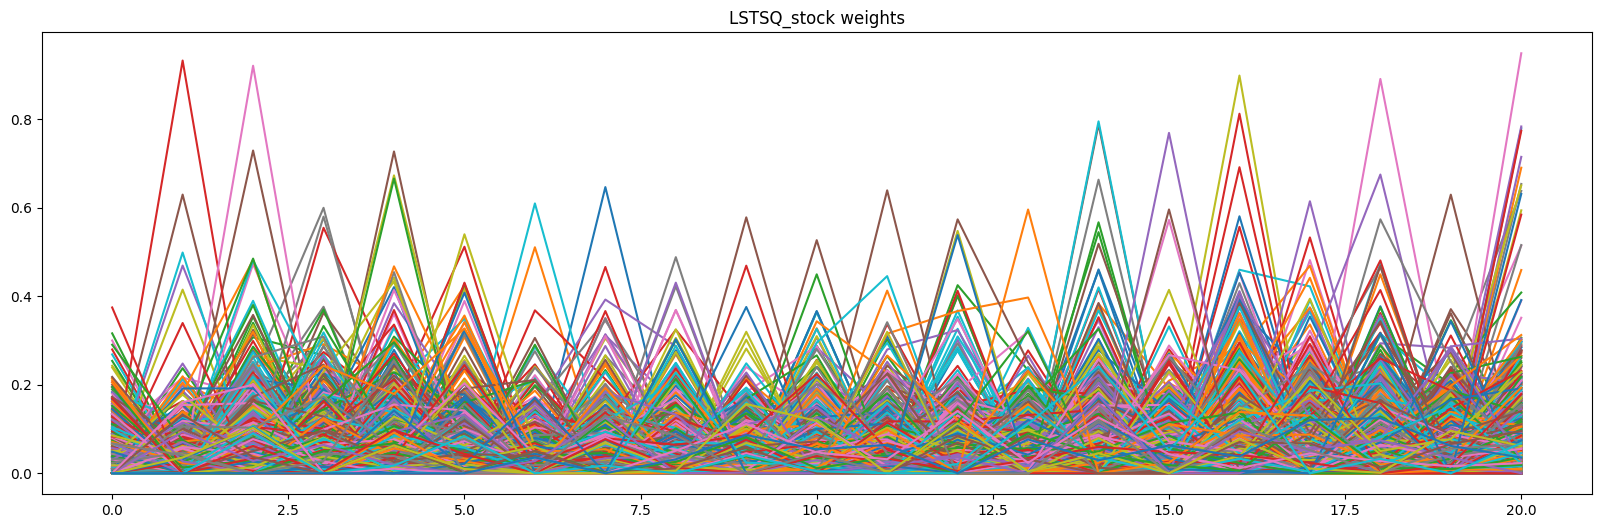

In [17]:
plt.figure(figsize=(20, 6))
for stock in selected_stocks:
    if not any(beta > 1 for beta in betas[stock]): 
        plt.plot(betas[stock])
plt.title("LSTSQ_stock weights")
#plt.xticks(np.arange(0, len(povrat_sample), 252), np.arange(2001, 2022, 1))
plt.show()

2.5608898528648045


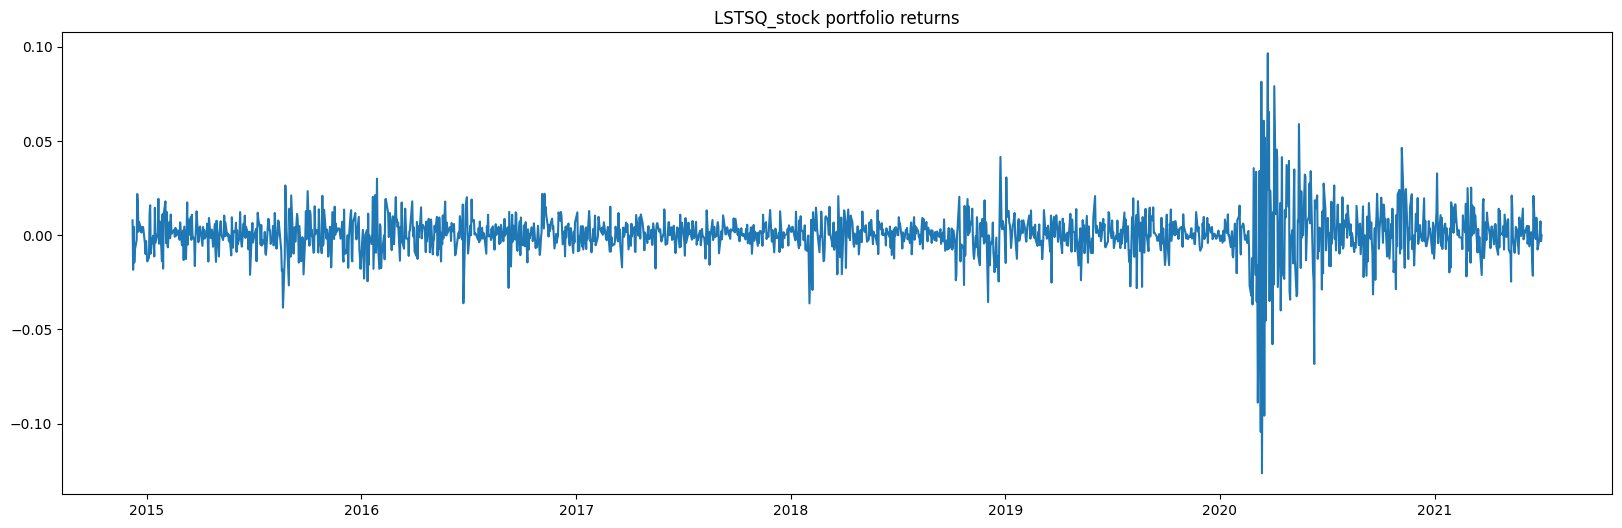

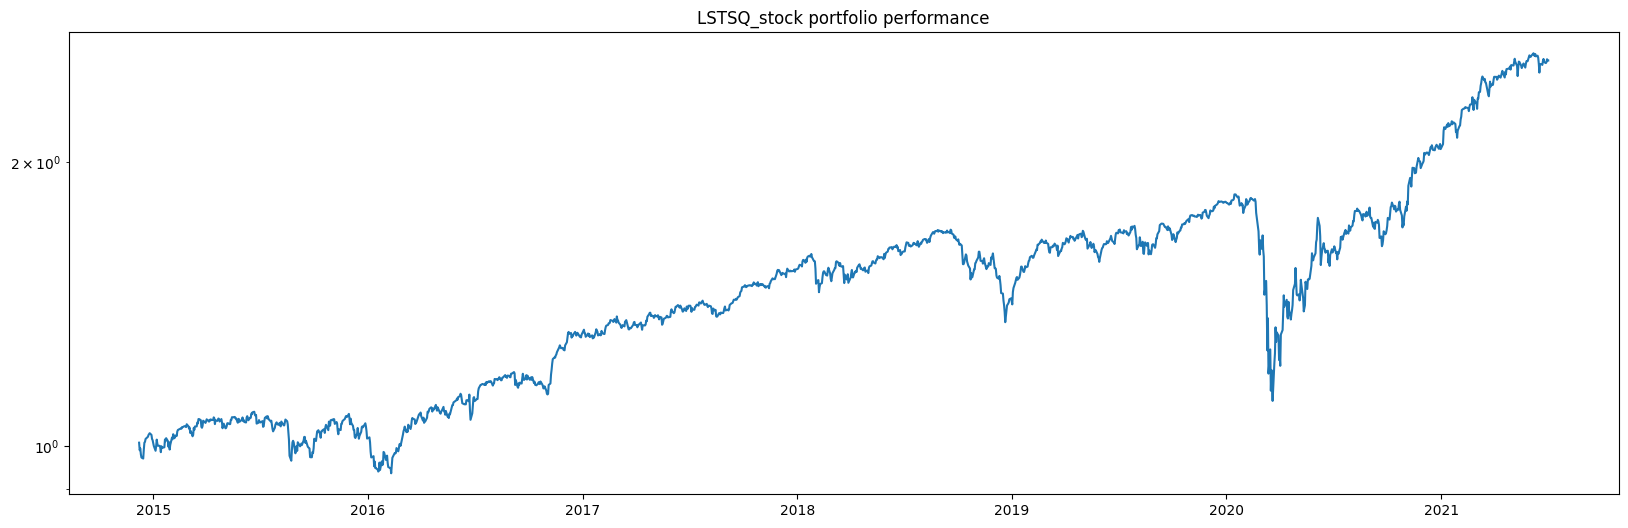

In [18]:
ukupno_lstsq_stock = [1]
povrat_lstsq_stock = []

#za svaki mjesec se pomicemo i racunamo volatilnost u intervalu godinu dana
for i in range(start, end, 21):
    volatility = {}
    for stock in selected_stocks:
        window_returns = returns_df[stock][i - len(betas[stock]):i]
        volatility[stock] = lstsq(betas[stock], window_returns)

        predicted_lsq_stock_volatility[stock].append(volatility[stock])
    
    #racunamo tezine s obzirom na volatilnost
    weights = get_portf_weights(volatility) # 1/len(volatilnost)
    #za svaki dan racunamo promjenu u portfelju
    

    vector = np.array(list(weights.values()))
    lstsq_stock_returns = np.dot(matrix[i:i+21], vector)
    for ret in lstsq_stock_returns:
        povrat_lstsq_stock.append(ret)
        ukupno_lstsq_stock.append((ret+1)*ukupno_lstsq_stock[-1])

print(ukupno_lstsq_stock[-1])

plt.figure(figsize=(20, 6))
plt.plot(dates, povrat_lstsq_stock)
plt.title("LSTSQ_stock portfolio returns")
plt.show()

plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_lstsq_stock[1:])
plt.title("LSTSQ_stock portfolio performance")
plt.show()

In [19]:
def get_mse(predicted_volatility, observed_volatility):
    #polje za mse svake dionice
    mse = []
    for stock_symbol in selected_stocks:
        mse.append(mean_squared_error(predicted_volatility[stock_symbol], observed_volatility[stock_symbol]))
    return np.mean(mse)

In [20]:
portfolio_df = [["Estimators (T = " + str(window) + " Trading Days)", "Standard Deviation", "Average Return", "Sharpe Ratio", 'Mean Squared Error']]

eq_portfolio = ["Equal Weight Portfolio"]

povrat_eq_df = pd.DataFrame(povrat_eq)

eq_std = povrat_eq_df.std() * 252**0.5
eq_return = (1 + povrat_eq_df.mean())**252 - 1
eq_sharpe = eq_return[0] / eq_std[0]

eq_portfolio.append(eq_std[0])
eq_portfolio.append(eq_return[0])
eq_portfolio.append(eq_sharpe)
portfolio_df.append(eq_portfolio)

sample_portfolio = ["Naive Risk Parity Portfolio"]

povrat_sample_df = pd.DataFrame(povrat_sample)

sample_std = povrat_sample_df.std() * 252**0.5
sample_return = (1 + povrat_sample_df.mean())**252 - 1
sample_sharpe = sample_return[0] / sample_std[0]

sample_portfolio.append(sample_std[0])
sample_portfolio.append(sample_return[0])
sample_portfolio.append(sample_sharpe)
sample_portfolio.append(get_mse(predicted_smp_volatility, observed_volatility))
portfolio_df.append(sample_portfolio)


ewma_portfolio = ["Exponentially Weighted Returns Portfolio"]

povrat_ewma_df = pd.DataFrame(povrat_ewma)

ewma_std = povrat_ewma_df.std() * 252**0.5
ewma_return = (1 + povrat_ewma_df.mean())**252 - 1
ewma_sharpe = ewma_return[0] / ewma_std[0]
ewma_portfolio.append(ewma_std[0])
ewma_portfolio.append(ewma_return[0])
ewma_portfolio.append(ewma_sharpe)
ewma_portfolio.append(get_mse(predicted_ewma_volatility, observed_volatility))
portfolio_df.append(ewma_portfolio)

lstsq_portfolio = ["Least-Squares Portfolio " + str(nnls_window)]

povrat_lstsq_df = pd.DataFrame(povrat_lstsq)

lstsq_std = povrat_lstsq_df.std() * 252**0.5
lstsq_return = (1 + povrat_lstsq_df.mean())**252 - 1
lstsq_sharpe = lstsq_return[0] / lstsq_std[0]

lstsq_portfolio.append(lstsq_std[0])
lstsq_portfolio.append(lstsq_return[0])
lstsq_portfolio.append(lstsq_sharpe)
lstsq_portfolio.append(get_mse(predicted_lsq_volatility, observed_volatility))
portfolio_df.append(lstsq_portfolio)

lstsq_stock_portfolio = ["Least-Squares (Stock) Portfolio " + str(nnls_window)]

povrat_lstsq_stock_df = pd.DataFrame(povrat_lstsq_stock)

lstsq_stock_std = povrat_lstsq_stock_df.std() * 252**0.5
lstsq_stock_return = (1 + povrat_lstsq_stock_df.mean())**252 - 1
lstsq_stock_sharpe = lstsq_stock_return[0] / lstsq_stock_std[0]

lstsq_stock_portfolio.append(lstsq_stock_std[0])
lstsq_stock_portfolio.append(lstsq_stock_return[0])
lstsq_stock_portfolio.append(lstsq_stock_sharpe)
lstsq_stock_portfolio.append(get_mse(predicted_lsq_stock_volatility, observed_volatility))
portfolio_df.append(lstsq_stock_portfolio)

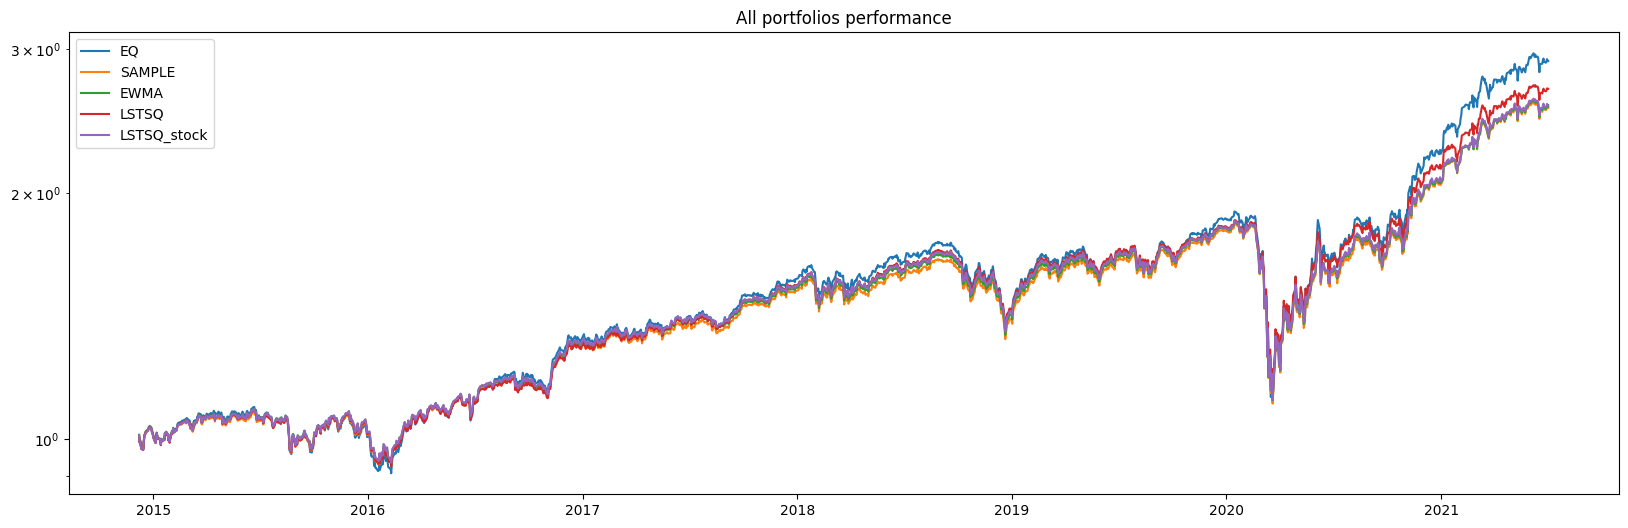

In [21]:
plt.figure(figsize=(20, 6))
plt.semilogy(dates, ukupno_eq[1:], label='EQ')
plt.semilogy(dates, ukupno_sample[1:], label='SAMPLE')
plt.semilogy(dates, ukupno_ewma[1:], label='EWMA')
plt.semilogy(dates, ukupno_lstsq[1:], label='LSTSQ')
plt.semilogy(dates, ukupno_lstsq_stock[1:], label='LSTSQ_stock')
plt.title("All portfolios performance")
plt.legend()
plt.show()